In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

import torch.optim.lr_scheduler as lr_scheduler

from tqdm.notebook import tqdm

from dataHandler.dataset import MHDProjDataset, LogNormalTransform
from ddpm.model import UNet, ResUNet
from ddpm.diffusion import DDPM, generate_image, NCSN, SigmaDDPM
from utils.plot import plot_and_save_line
from utils.scheduler import WarmUp

In [2]:
## Constants and folders
####################################################################################

MODEL_ID='MHD_SigmaDDPM_test_white_noise'

SOURCE_DIR='/mnt/home/dheurtel/ceph/00_exploration_data/density/b_proj/'

SAMPLE_FOLDER='/mnt/home/dheurtel/ceph/20_samples/artificial_architecture_exps/'  #For periodic samples
CKPT_FOLDER='/mnt/home/dheurtel/ceph/10_checkpoints/artificial_architecture_exps/' #For checkpoints and losses


SIZE=256

N_STEPS=1000
BATCH_SIZE=64
SAMPLE_BATCH_SIZE=8
RESULT_SAMPLE_SIZE=8



SAVE_STEP_EPOCH=100
SAMPLE_STEP_EPOCH=100

NUM_EPOCHS=500
LR=1e-3

IN_C=1

MODEL_TYPE = 'SigmaDDPM'

POWER_SPECTRUM_FILE = '/mnt/home/dheurtel/ceph/00_exploration_data/power_spectra/same.npy'

In [3]:
POWER_SPECTRUM = np.load(POWER_SPECTRUM_FILE, allow_pickle=True).astype(np.float32)

In [4]:
POWER_SPECTRUM

array([[1.2951418e-11, 3.5393962e+03, 3.1011653e+03, ..., 8.8347565e+02,
        3.1011653e+03, 3.5393962e+03],
       [3.6453567e+03, 5.9500503e+03, 1.6007991e+03, ..., 1.0906501e+03,
        1.5246516e+03, 5.9527344e+03],
       [3.1446960e+03, 1.5090220e+03, 1.4877487e+03, ..., 6.4616638e+02,
        1.5384125e+03, 1.6598842e+03],
       ...,
       [9.2986761e+02, 1.0565588e+03, 6.7294379e+02, ..., 4.5764880e+02,
        6.5378564e+02, 1.0902323e+03],
       [3.1446960e+03, 1.6598842e+03, 1.5384125e+03, ..., 6.8198920e+02,
        1.4877487e+03, 1.5090220e+03],
       [3.6453567e+03, 5.9527344e+03, 1.5246516e+03, ..., 1.0990735e+03,
        1.6007991e+03, 5.9500503e+03]], dtype=float32)

In [5]:
delta = np.ones((SIZE, SIZE)).astype(np.float32)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
dataset=MHDProjDataset(SOURCE_DIR,test_batch_length=95,random_rotate=True,transforms=LogNormalTransform())
#dataset=MHDProjDataset(SOURCE_DIR,test_batch_length=30,random_rotate=False,transforms=None)

In [8]:
amin,amax=(-6.232629, 7.390278)

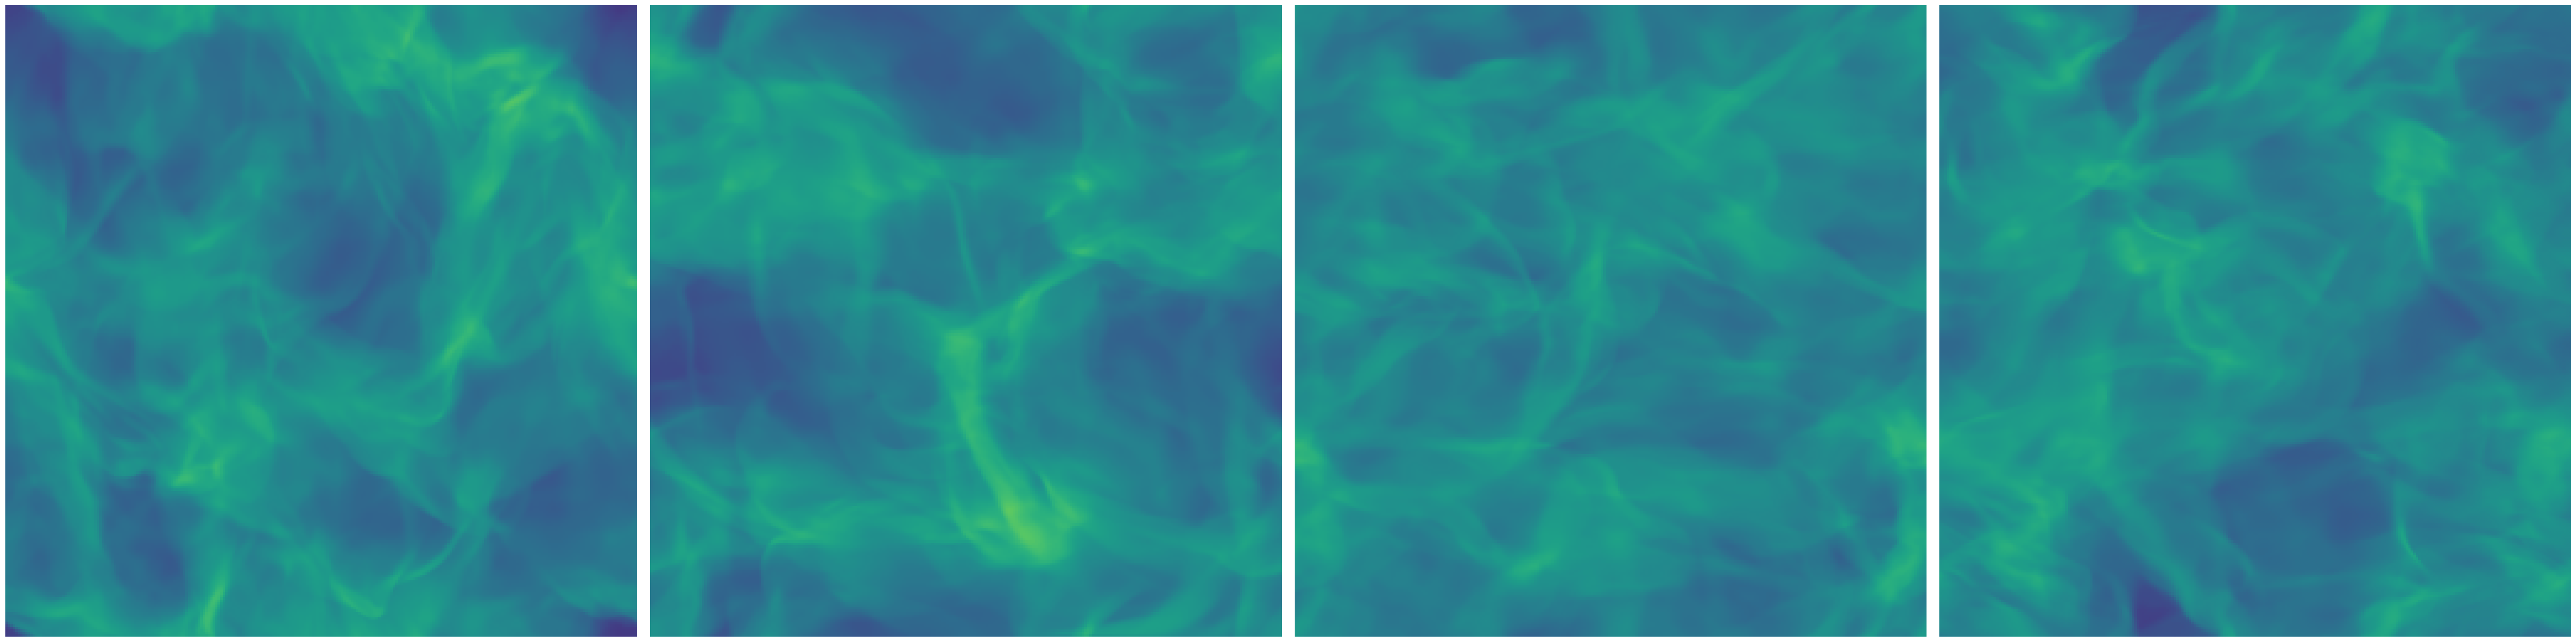

In [9]:
plot_and_save_line([dataset[i] for i in range(4)], amin = amin, amax = amax)

In [10]:
dataloader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

In [11]:
network = ResUNet(in_c=IN_C, out_c=IN_C, first_c= 10, sizes= [256, 128, 64, 32, 16], num_blocks= 1, n_steps= 1000, time_emb_dim= 100, dropout= 0.1, attention= [], normalisation= 'GN', padding_mode='zeros',skiprescale=True)
network = network.to(device)

model = SigmaDDPM(network, N_STEPS, torch.from_numpy(delta), beta_start=0.0001, beta_end=0.02, device=device)

In [12]:
def training_loop(model, dataloader, optimizer, num_epochs, num_timesteps, device=device,test_loss_batch=None,scheduler=None):
    """Training loop for DDPM"""

    try:
        os.mkdir(os.path.join(CKPT_FOLDER,MODEL_ID))
    except:
        pass
    try:
        os.mkdir(os.path.join(SAMPLE_FOLDER,MODEL_ID))
    except:
        pass

    global_step = 0
    losses = []
    test_losses_epoch=[]
    steps_per_epoch=len(dataloader)


    for epoch in range(num_epochs):

        model.train()

        progress_bar = tqdm(total=steps_per_epoch)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(dataloader):
            if len(batch.shape)==3:
                batch = batch.to(device).unsqueeze(1)
            else:
                batch = batch.to(device)

            noise = torch.randn(batch.shape).to(device)
            timesteps = torch.randint(0, num_timesteps, (batch.shape[0],)).long().to(device)

            loss=model.loss(timesteps, batch, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "step": global_step}
            losses.append(loss.detach().item())
            progress_bar.set_postfix(**logs)
            global_step += 1

        progress_bar.close()

        if not(scheduler is None):
            scheduler.step()

        if (epoch%SAVE_STEP_EPOCH==0) or (epoch==num_epochs-1):

            ckpt= {'ddpm_model': model.state_dict(),'test_set': dataloader.dataset.test_file_list}
            torch.save(ckpt,os.path.join(CKPT_FOLDER,MODEL_ID,'ckpt.pt'))
            np.save(os.path.join(CKPT_FOLDER,MODEL_ID,'losses'),np.array(losses,dtype=float))
            np.save(os.path.join(CKPT_FOLDER,MODEL_ID,'test_losses'),np.array(test_losses_epoch,dtype=float))
            np.save(os.path.join(CKPT_FOLDER,MODEL_ID,'steps_per_epoch'),np.array(steps_per_epoch))

        if (epoch%SAMPLE_STEP_EPOCH==0) and (epoch!=num_epochs-1):

            generated, _ = generate_image(model, SAMPLE_BATCH_SIZE, IN_C, SIZE)

            for i in range(SAMPLE_BATCH_SIZE):

                np.save(os.path.join(SAMPLE_FOLDER,MODEL_ID,'sample_'+str(epoch).zfill(4)+'_'+str(i)),generated[i].numpy())

        if (epoch==num_epochs-1):

            generated, _ = generate_image(model, RESULT_SAMPLE_SIZE, IN_C, SIZE)

            for i in range(RESULT_SAMPLE_SIZE):

                np.save(os.path.join(SAMPLE_FOLDER,MODEL_ID,'result_'+str(i).zfill(3)),generated[i].numpy())

        if not(test_loss_batch is None):
            with torch.no_grad():
                batch = test_loss_batch.to(device)
                noise = torch.randn(batch.shape).to(device)
                timesteps = torch.randint(0, num_timesteps, (batch.shape[0],)).long().to(device)

                loss=model.loss(timesteps,batch, noise).detach().cpu().item()
            test_losses_epoch.append(loss)
    return steps_per_epoch,losses,test_losses_epoch

In [13]:
optimizer = torch.optim.AdamW(network.parameters(), lr=1e-3, weight_decay = 1e-4)

scheduler=lr_scheduler.StepLR(optimizer,step_size=100,gamma=0.5) 

#scheduler = WarmUp(optimizer, scheduler, 100 , 1e-3)

In [14]:

n,l,tl=training_loop(model, dataloader, optimizer, 1000, N_STEPS, device=device, test_loss_batch=dataset.test_batch(),scheduler=scheduler)

  0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:10<00:00, 98.90it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:10<00:00, 99.49it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:10<00:00, 99.40it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [16]:
ckpt = torch.load(os.path.join(CKPT_FOLDER, MODEL_ID, 'ckpt.pt'),map_location=torch.device('cpu'))
losses=np.load(os.path.join(CKPT_FOLDER,MODEL_ID,'losses.npy'),allow_pickle=True)
test_losses=np.load(os.path.join(CKPT_FOLDER,MODEL_ID,'test_losses.npy'),allow_pickle=True)
steps_per_epoch=np.load(os.path.join(CKPT_FOLDER,MODEL_ID,'steps_per_epoch.npy'),allow_pickle=True)

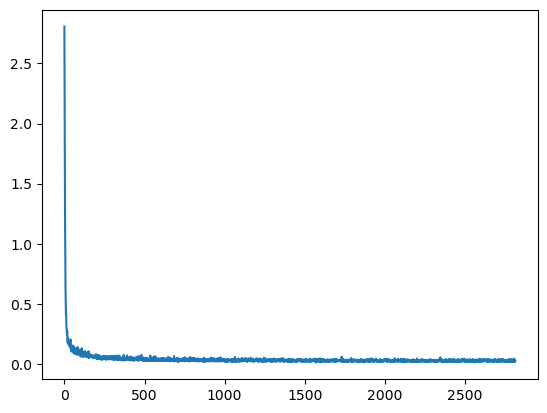

In [17]:
plt.plot(losses)

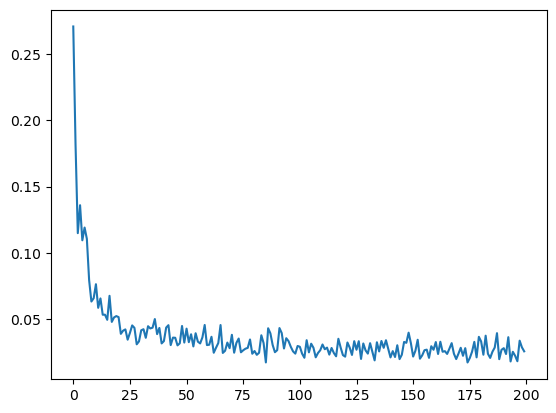

In [18]:
plt.plot(test_losses)

In [19]:
model.load_state_dict(ckpt['ddpm_model'])

<All keys matched successfully>

In [24]:
file_list = ckpt['test_set']
dataset = MHDProjDataset(SOURCE_DIR, transforms=LogNormalTransform(),random_rotate=True, test_batch_length=95 ,  test_file_list=file_list)

In [27]:
test_batch = dataset.test_batch()
test_batch = test_batch.to(device)

noise_step = 200
time_steps = torch.ones(test_batch.shape[0], dtype=torch.long, device=device) * noise_step
noise_level = model.sqrt_alphas_cumprod[noise_step]/model.sqrt_one_minus_alphas_cumprod[noise_step]
noise_level

tensor(1.3820, device='cuda:0')

In [32]:
noisy = model.add_noise(test_batch, torch.randn_like(test_batch), time_steps)[0]

In [35]:
gen, _ = generate_image(model, 95, IN_C, SIZE, sample=noisy, initial_timestep=noise_step)

100%|██████████| 200/200 [00:16<00:00, 12.36it/s]


Text(0.5, 0.98, 'Reconstruction Process for the whole dataset. Top-down: Baseline, Reconstructed, Intermediate step, Noisy Input (Baseline + Noise)')

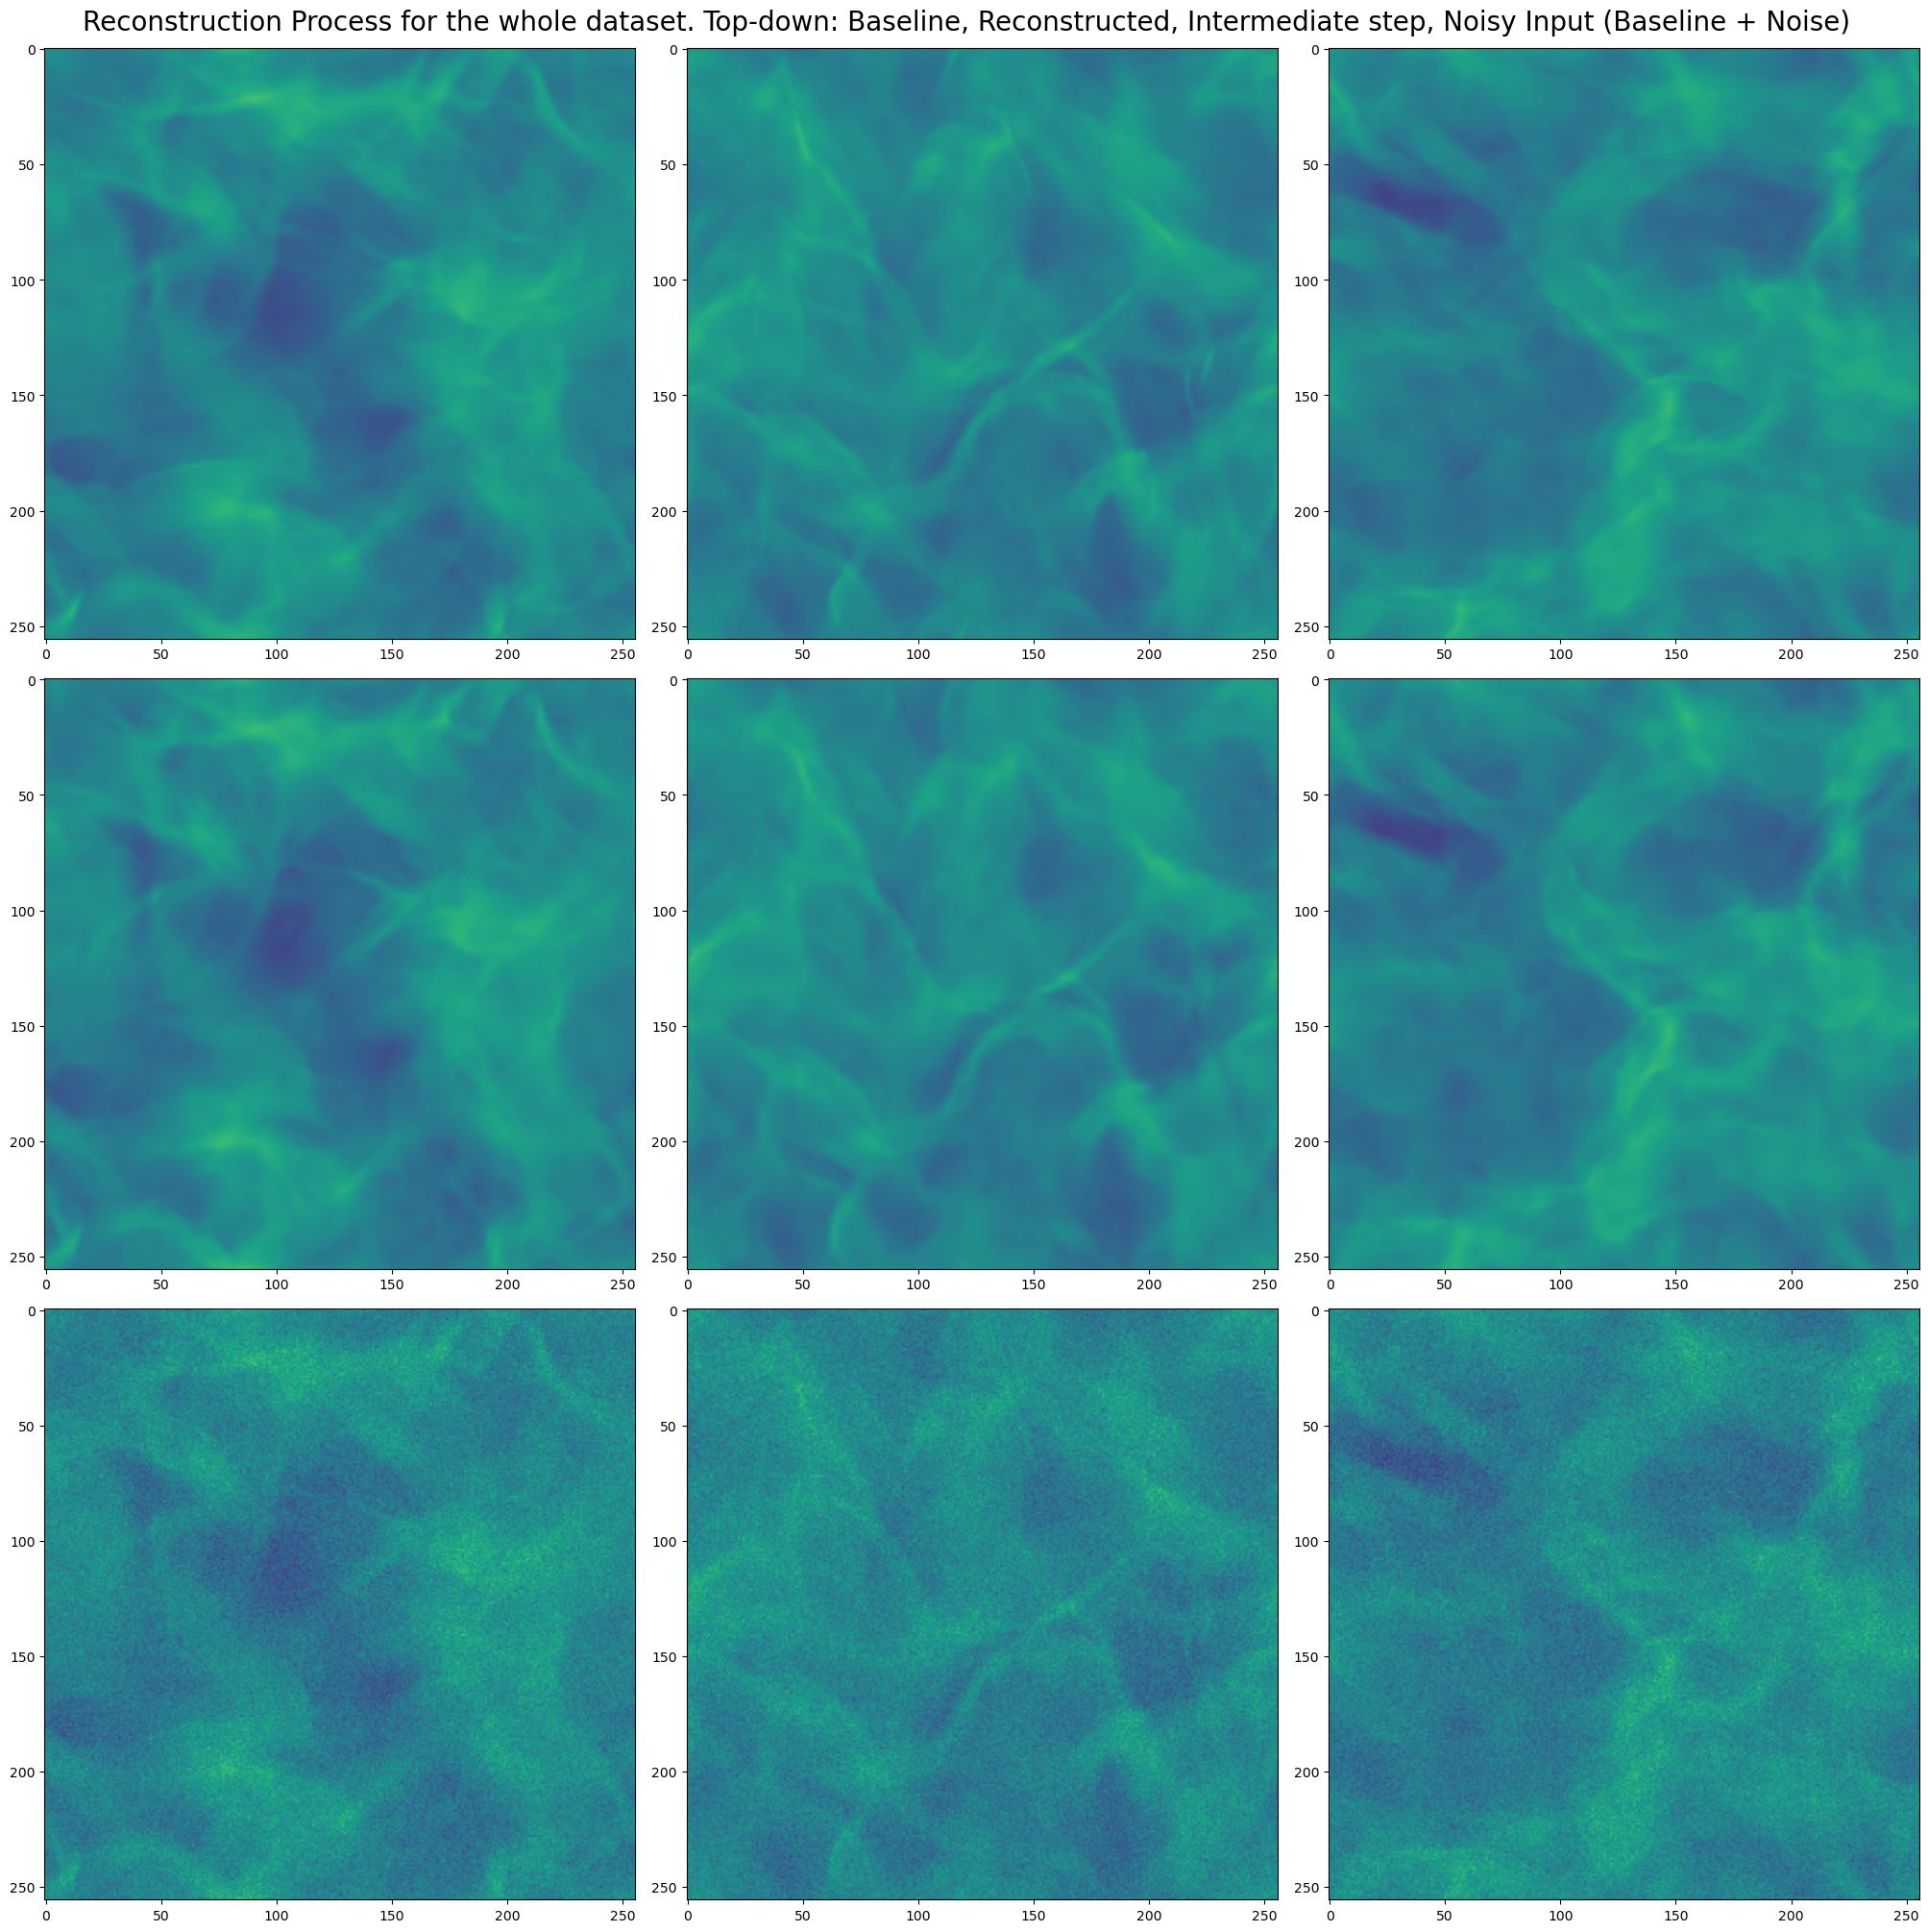

In [37]:
fig=plt.figure(constrained_layout=True,figsize=(20,20))
ax= fig.subplots(3,3)

for i in range(3):
    ax[0,i].imshow(test_batch.cpu().detach()[i][0],vmin=amin,vmax=amax)
    ax[1,i].imshow(gen[i][0],vmin=amin,vmax=amax)
    ax[2,i].imshow(noisy.cpu().detach()[i][0],vmin=amin,vmax=amax)
fig.suptitle('Reconstruction Process for the whole dataset. Top-down: Baseline, Reconstructed, Intermediate step, Noisy Input (Baseline + Noise)', fontsize=20)